# **Exploratory Data Analysis, Hypothesis Testing, and Machine Learning**

Before statiscal testing for the hypotheses, EDA will be conducted to better understand and visualize the nature of my data. After hypothesis testing, Machine Learning methods will be applied.

## **Importing and Setting the Libraries, Preparing the Data**
The following libraries must be used in order to read data from JSON files, manipulate and visualize the data.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline
sns.set(style='whitegrid')

Set the path and read all the JSON files. Read all data into `games` list.

In [2]:
directory_path = Path("")
json_files = list(directory_path.glob("*.json"))

games = []
for file_path in json_files:
    with open(file_path, "r") as file:
        data = json.load(file)
        games.extend(data["games"])

To include the time data for each move, we need to extract it from the PGN of each game. Function `extract_move_times` extracts the timestamps of my each move, which is given in format of how much time is left in the clock. Then by subtracting the time value at a particular move from the previous move's time value, we get the time spent on that particular move.

We create a list for storing the time spent for the moves in the respective indices of the list.

_For Example: `times_seconds = [0, 1.1, 1.3, 4.5, 2.2]` implies the 1st move is done immediately, the 2nd move is completed in 1.1 seconds, the 3rd move is completed in 1.3 seconds, and so on. Note that these **my** data only._

In [3]:
import re

def extract_move_times(row):

    pgn = row['pgn']
    try:
      timecontrol = float(row['time_control'])
    except:
      return [];
    prevtime = timecontrol
    if row["white"]["username"] == "MrEKO0": # My username.
        side = "white"
    else:
        side = "black"

    # Assistance from ChatGPT for the usage of the "re" library for extracting time data.
    # This regex pattern finds move times enclosed in brackets, like {[%clk 0:01:00]}
    times = re.findall(r'\{\[%clk ([^\]]+)\]\}', pgn)

    # Convert the times to seconds and select only my move times and not my opponent's
    times_seconds = []
    for i, time_str in enumerate(times):
        if (side == 'white' and (i % 2 == 0)) or \
           (side == 'black' and (i % 2 != 0)):  # Check if it's my turn
            # Handle time strings with hours, minutes, and seconds
            time_parts = list(map(float, time_str.split(':')))
            if len(time_parts) == 2:  # If only minutes and seconds are present
                minutes, seconds = time_parts
            elif len(time_parts) == 3:  # If hours, minutes, and seconds are present
                hours, minutes, seconds = time_parts
                minutes = hours * 60 + minutes # Convert hours to minutes for calculation
            else:
                # Handle unexpected time string formats (if any)
                print(f"Warning: Unexpected time string format: {time_str}")
                continue  # Skip to the next time string
            total_seconds = minutes * 60 + seconds
            times_seconds.append(prevtime - total_seconds) # Time spent on each move.
            prevtime = total_seconds
    return times_seconds

We form the data frame with the data we got from the reading of JSON files, and the data we will be extracting with the function `extract_move_times` we created.

In [4]:
records = []
for game in games:
    if game["white"]["username"] == "MrEKO0":
      result = game["white"]["result"]
      side = "white"
    else:
      result = game["black"]["result"]
      side = "black"
    records.append({
        "side" : side, # With which pieces I am playing? Either black or white.
        "move_times" : extract_move_times(game), # Use the function to get list for each game.
        "pgn" : game["pgn"], # Include the raw PGN too in case of for further use.
        "result": result, # Win, checkmated, timeout...
        "time_class": game["time_class"], # Blitz, bullet, rapid.
        "time_control": game["time_control"] # 600, 300, 180 etc. (in seconds)
    })

df = pd.DataFrame(records)
df.head()

,side,move_times,pgn,result,time_class,time_control
0,white,"[0.0, 0.6000000000000014, 0.8999999999999986, ...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",win,bullet,60
1,black,"[0.29999999999999716, 0.7000000000000028, 1.39...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",timeout,bullet,60
2,black,"[0.0, 0.5, 0.7999999999999972, 1.5, 0.5, 1.0, ...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",checkmated,bullet,60
3,black,"[0.0, 0.29999999999999716, 0.20000000000000284...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",checkmated,bullet,60
4,white,"[0.0, 0.3999999999999986, 0.7000000000000028, ...","[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",timeout,bullet,60


Empty lists to later store data according to `time_class` separately. We need to do this for plotting since `move_times` data of each game is in list format and difficult to use in plotting.

In [5]:
all_move_numbers_win = []
all_move_times_win = []
all_move_numbers_loss = []
all_move_times_loss = []

blitz_move_numbers_win = []
blitz_move_times_win = []
blitz_move_numbers_loss = []
blitz_move_times_loss = []

bullet_move_numbers_win = []
bullet_move_times_win = []
bullet_move_numbers_loss = []
bullet_move_times_loss = []

rapid_move_numbers_win = []
rapid_move_times_win = []
rapid_move_numbers_loss = []
rapid_move_times_loss = []

Fill the lists with move numbers (the indices), and time spent.

In [6]:
for index, row in df.iterrows():
    move_times_list = row['move_times']
    result = row['result']
    time_class = row['time_class']

    for i, move_time in enumerate(move_times_list): # Iterate over indexes and time values.
        if result == 'win': # The games I won.
            all_move_numbers_win.append(i + 1) # Moves start from 1.
            all_move_times_win.append(move_time)
            if time_class == 'blitz':
                blitz_move_numbers_win.append(i + 1)
                blitz_move_times_win.append(move_time)
            elif time_class == 'bullet':
                bullet_move_numbers_win.append(i + 1)
                bullet_move_times_win.append(move_time)
            elif time_class == 'rapid':
                rapid_move_numbers_win.append(i + 1)
                rapid_move_times_win.append(move_time)
        elif result in ('checkmated', 'resigned', 'timeout', 'abandoned'): # Lost games.
            all_move_numbers_loss.append(i + 1)
            all_move_times_loss.append(move_time)
            if time_class == 'blitz':
                blitz_move_numbers_loss.append(i + 1)
                blitz_move_times_loss.append(move_time)
            elif time_class == 'bullet':
                bullet_move_numbers_loss.append(i + 1)
                bullet_move_times_loss.append(move_time)
            elif time_class == 'rapid':
                rapid_move_numbers_loss.append(i + 1)
                rapid_move_times_loss.append(move_time)

## **EDA and Visualization**

We will visualize our data to uncover possible correlations, to evaluate and form initial reflections.

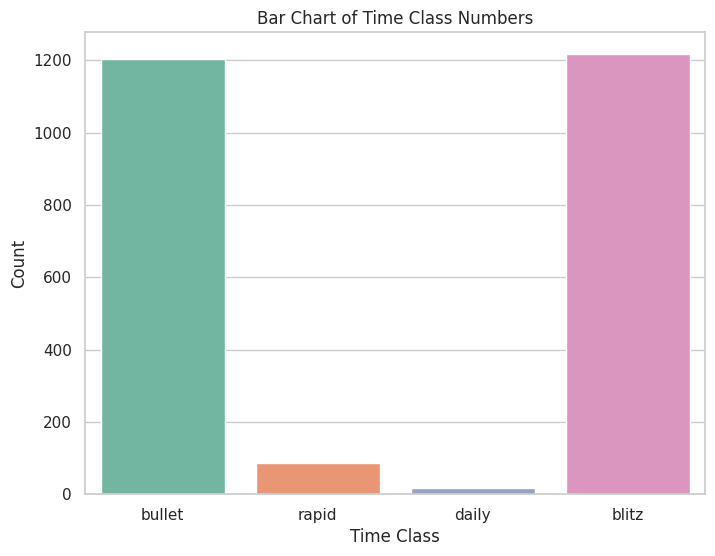

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='time_class', palette= 'Set2', hue= 'time_class', legend=False)
plt.title('Bar Chart of Time Class Numbers')
plt.xlabel('Time Class')
plt.ylabel('Count')
plt.show()

In our data, we have a very low amount of *daily* games. It would be better to exclude *daily* games from our analysis; since there is less data regarding it, and the outcomes/timings of them are often complex and confusing, not appropriate for driving general information.

Visualize which piece I am playing with, in how many games.

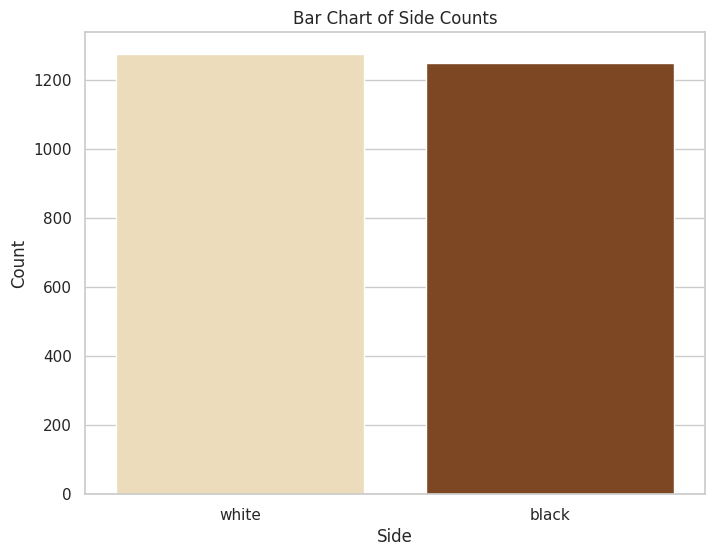

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='side', palette= ['Wheat', 'Saddlebrown'], hue = 'side', legend = False)
plt.title('Bar Chart of Side Counts')
plt.xlabel('Side')
plt.ylabel('Count')
plt.show()

Game Results Frequency

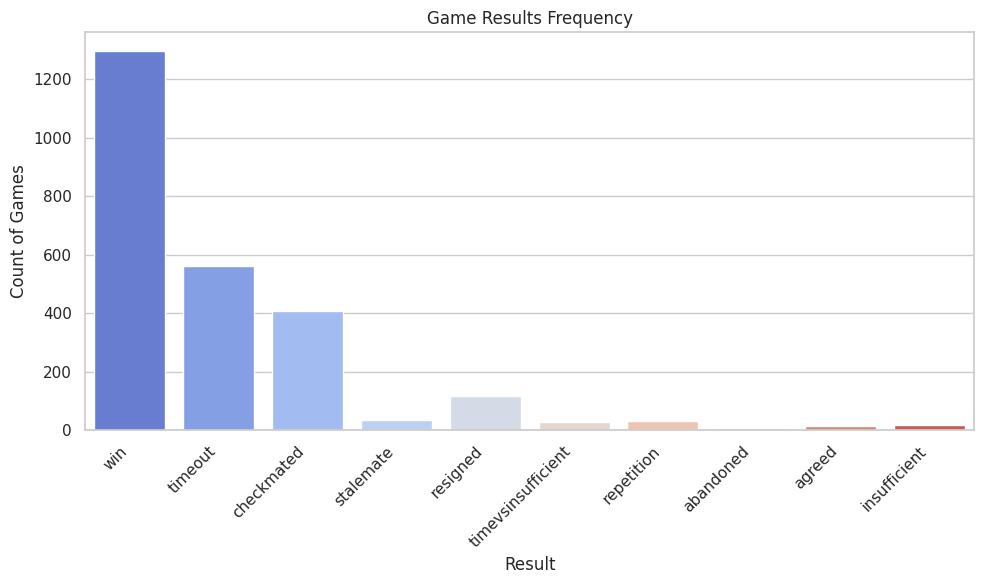

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='result', hue ='result', palette = 'coolwarm', legend = False)
plt.title('Game Results Frequency')
plt.xlabel('Result')
plt.ylabel('Count of Games')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Box plot for relation between Time Spent per Move and the Outcome of the Game (win-loss)

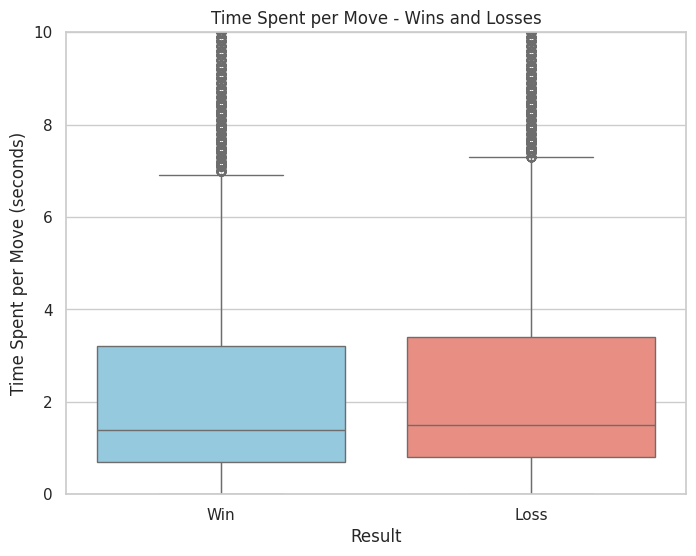

In [10]:
df1 = pd.DataFrame({
    'Move Time (seconds)': all_move_times_win + all_move_times_loss,
    'Result': ['Win'] * len(all_move_times_win) + ['Loss'] * len(all_move_times_loss)
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Result', y='Move Time (seconds)', data=df1, palette=['skyblue', 'salmon'], hue='Result', legend=False)
plt.title('Time Spent per Move - Wins and Losses')
plt.xlabel('Result')
plt.ylabel('Time Spent per Move (seconds)')
plt.ylim(0, 10)
plt.grid(True)
plt.show()

Loss games appear to have a higher average of time spent per move, compared to win games. While both Win and Loss games have many outliers. Outliers indicate there exists moves I spent much time compared to other moves. In our case we must also take account of these moves, because they are not extreme values, but rather moves that will occur in any game.

Calculate "Average Move Time per Game" for each game: Simply by dividing the sum of the time spent to complete each move in a game, to the move length of the game.

In [11]:
df['avg_move_time'] = df['move_times'].apply(lambda x: sum(x) / len(x) if x else 0)

Let us create a histogram to display the distribution of the averages. Also I will enable `kde` to visualize a smooth, best-fit curve representing the densities.

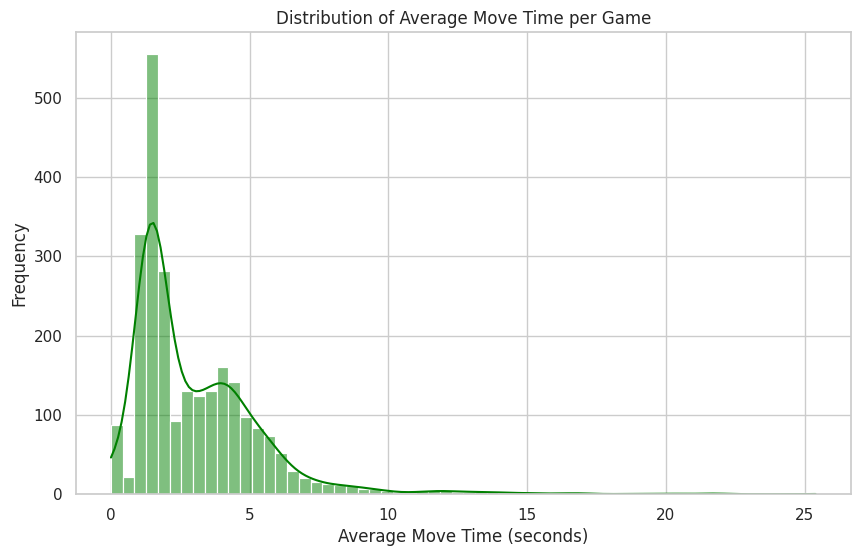

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df['avg_move_time'], kde=True, bins=60, color='green')
plt.title("Distribution of Average Move Time per Game")
plt.xlabel("Average Move Time (seconds)")
plt.ylabel("Frequency")
plt.show()

We must note that the remarkable frequency of averages near 0 can be caused by reasons including:

- **Premoves:** Premoves are moves I made during my opponent's turn. The move is executed automatically - typically in less than a second, once it's my turn. This is mainly because either I predict the next move of my opponent, or I have very low time left on the clock.

- **Fast-Paced Games:** Especially Bullet Games are very fast-paced and generally it contains many moves that are made in a blink time, along with many premoves.

Now let's compare Win and Loss games.

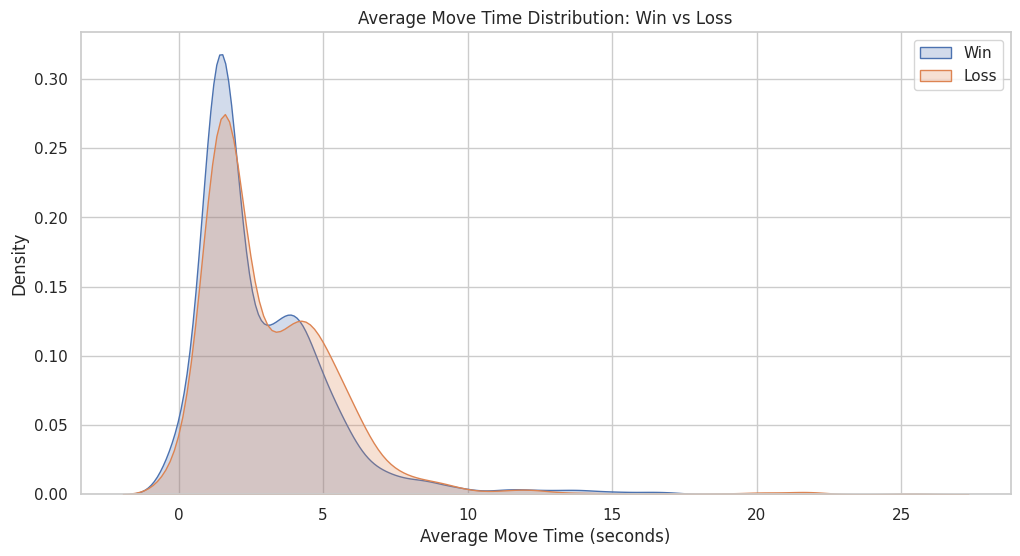

In [13]:
df_win = df[df['result'] == 'win']
df_loss = df[df['result'].isin(['checkmated', 'resigned', 'timeout', 'abandoned'])]

plt.figure(figsize=(12, 6))
sns.kdeplot(df_win['avg_move_time'], label='Win', fill=True)
sns.kdeplot(df_loss['avg_move_time'], label='Loss', fill=True)
plt.legend()
plt.title("Average Move Time Distribution: Win vs Loss")
plt.xlabel("Average Move Time (seconds)")
plt.show()

Create scatter plot for **All Games**

The time spent on a particular move. The *x-axis* is the move no's (1st move, 2nd move, and so on) and the *y-axis* is the time spent on making that particular move.

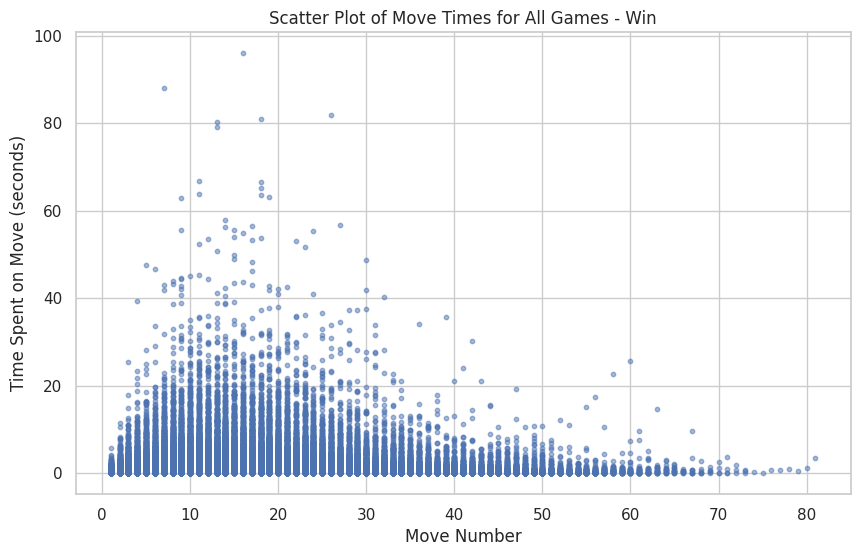

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(all_move_numbers_win, all_move_times_win, s=10, alpha=0.5)
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for All Games - Win')
plt.grid(True)
plt.show()

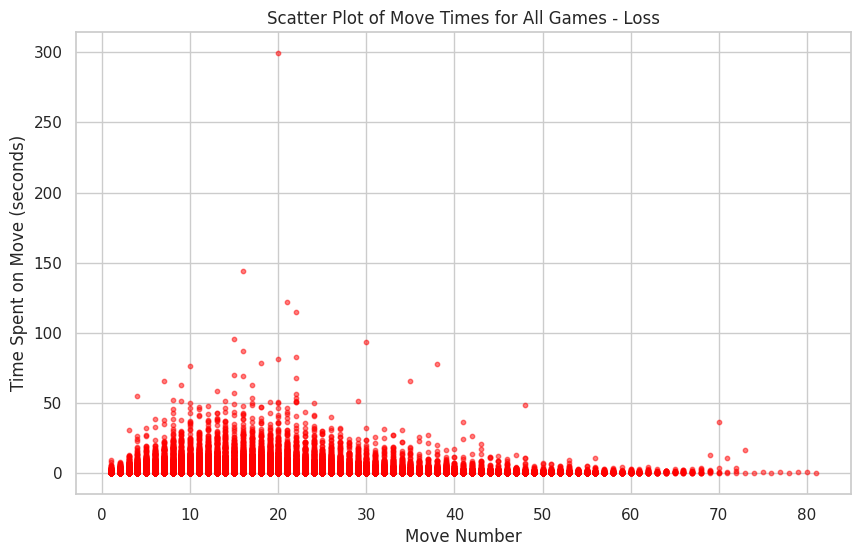

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(all_move_numbers_loss, all_move_times_loss, s=10, alpha=0.5, color='red')
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for All Games - Loss')
plt.grid(True)
plt.show()

Create scatter plots for **Blitz Games**

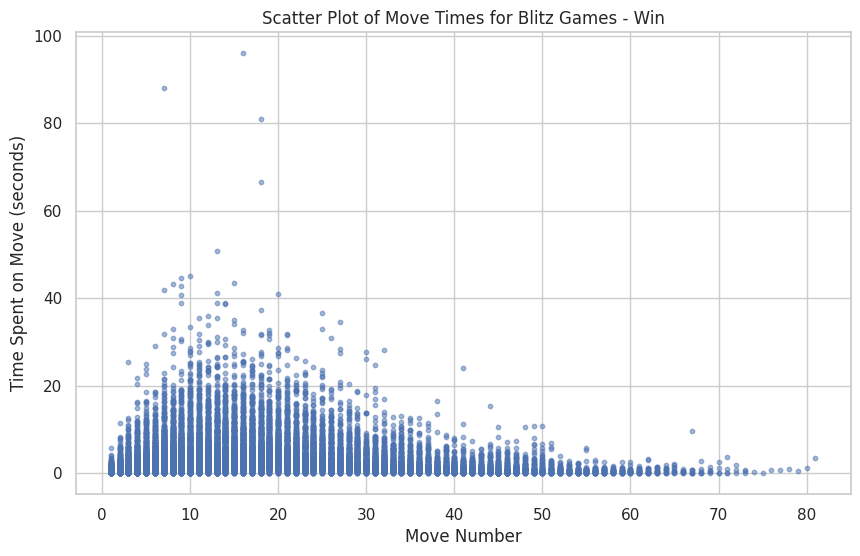

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(blitz_move_numbers_win, blitz_move_times_win, s=10, alpha=0.5)
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for Blitz Games - Win')
plt.grid(True)
plt.show()

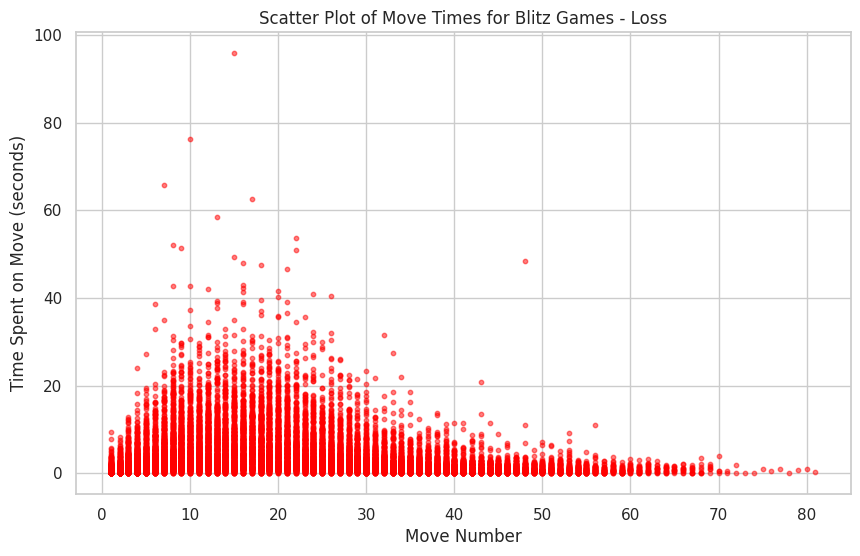

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(blitz_move_numbers_loss, blitz_move_times_loss, s=10, alpha=0.5, color='red')
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for Blitz Games - Loss')
plt.grid(True)
plt.show()

Create scatter plots for **Bullet Games**

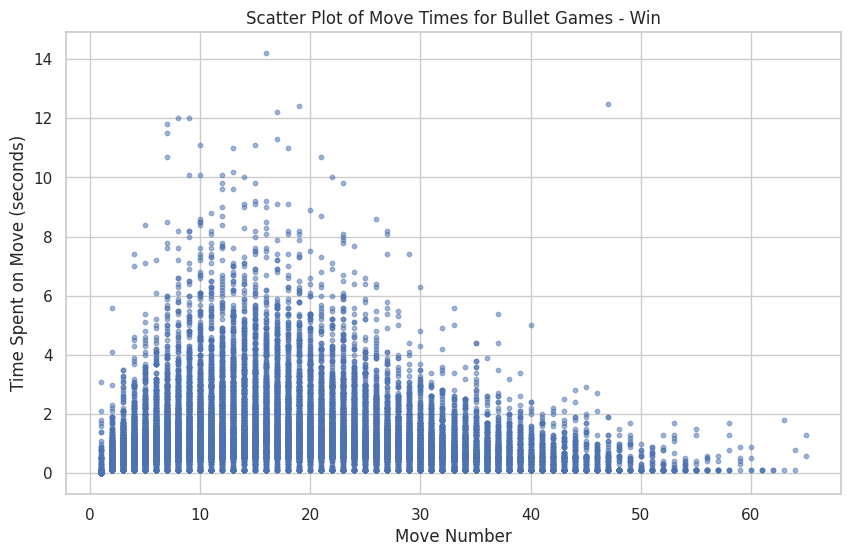

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(bullet_move_numbers_win, bullet_move_times_win, s=10, alpha=0.5)
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for Bullet Games - Win')
plt.grid(True)
plt.show()

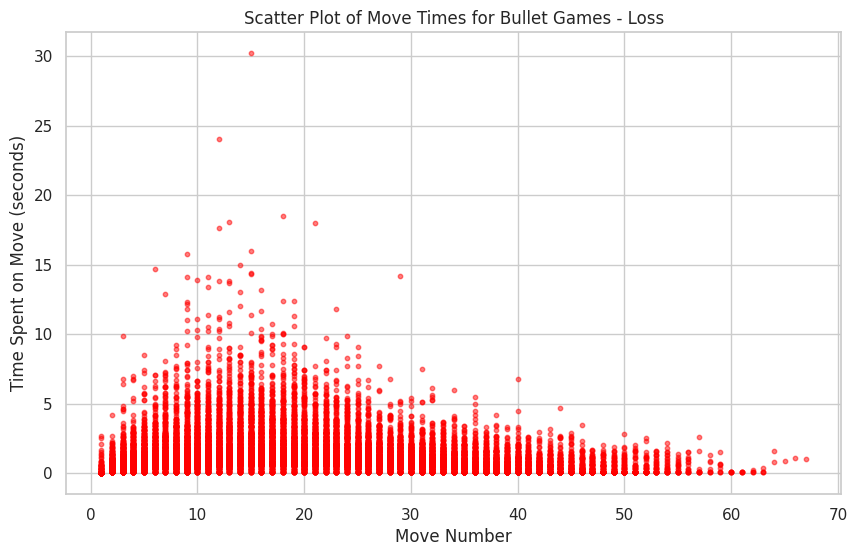

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(bullet_move_numbers_loss, bullet_move_times_loss, s=10, alpha=0.5, color='red')
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for Bullet Games - Loss')
plt.grid(True)
plt.show()

Create scatter plots for **Rapid Games**

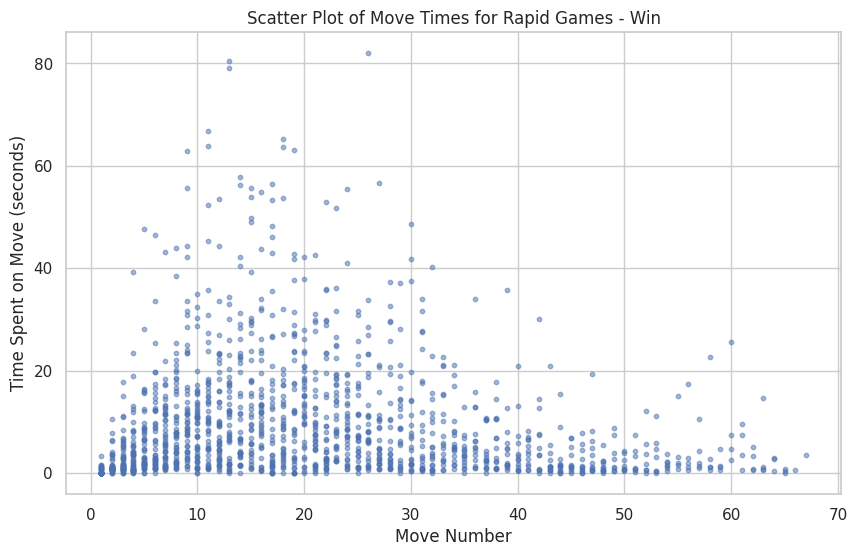

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(rapid_move_numbers_win, rapid_move_times_win, s=10, alpha=0.5)
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for Rapid Games - Win')
plt.grid(True)
plt.show()

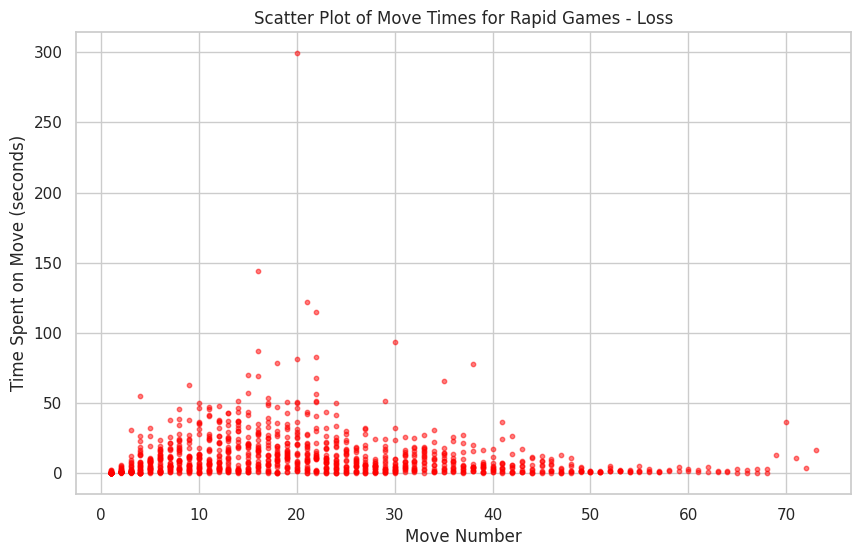

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(rapid_move_numbers_loss, rapid_move_times_loss, s=10, alpha=0.5, color='red')
plt.xlabel('Move Number')
plt.ylabel('Time Spent on Move (seconds)')
plt.title('Scatter Plot of Move Times for Rapid Games - Loss')
plt.grid(True)
plt.show()

## **Hypothesis Testing**
**Null Hypothesis (H₀):** There is no distinct, unique pattern in the time I spend on each move in the games I won when the moves of the whole game are divided into equal phases. The time distribution pattern in winning games does not differ significantly from the time distribution pattern observed in games I lost. Any observed difference between winning and losing games is due to random variation rather than consistent patterns.

**Alternative Hypothesis (H₁):** The time I spend on each move in the games I won follows a unique, distinct pattern when the moves of the whole game are divided into equal phases, and this pattern differs significantly from the time distribution pattern observed in games I lost.

In [22]:
from scipy import stats

For convenience and better testing, we will separate games according to their categories: All, Blitz, Bullet, Rapid.

In the following code we generate dictionaries with keys being the move no's and values being the time spent data combined for that particular move.

We will conduct two sample (Win & Loss) t-test's for each move separately. This is because each move is a discrete variable. We will then come up with a general idea.

In [23]:
# Dictionaries for move data. Keys are move no's.
move_win_dict = {i: [] for i in range(1, 200)}  # 200 to safely include all moves.
move_loss_dict = {i: [] for i in range(1, 200)}

# Fill the dicts: Win
for move_time, move_number in zip(all_move_times_win, all_move_numbers_win):
    if move_number in move_win_dict:
        move_win_dict[move_number].append(move_time)

# Loss
for move_time, move_number in zip(all_move_times_loss, all_move_numbers_loss):
    if move_number in move_loss_dict:
        move_loss_dict[move_number].append(move_time)

count = 0
for move_number in range(1, 75): # We observe insufficient data above this limit, because there are few games in such length.
  t_statistic, p_value = stats.ttest_ind(move_win_dict[move_number], move_loss_dict[move_number], equal_var=False)
  if p_value < 0.05:
    count += 1
  print(f"Move Number: {move_number} t-stat: {t_statistic} p_value: {p_value}")

print(f"\nTotal count of moves that yielded a significant difference: {count}")


Move Number: 1 t-stat: -2.8211112585435996 p_value: 0.004835902554799698
Move Number: 2 t-stat: 0.10947677799473543 p_value: 0.9128338863901837
Move Number: 3 t-stat: -1.0935996613007202 p_value: 0.2742503567185655
Move Number: 4 t-stat: -1.343641581193282 p_value: 0.179210915803008
Move Number: 5 t-stat: -0.9169779465429571 p_value: 0.35925240801588254
Move Number: 6 t-stat: -2.0828215973577953 p_value: 0.03738220990840226
Move Number: 7 t-stat: -0.9338137489160748 p_value: 0.3505001168445795
Move Number: 8 t-stat: -2.7296316371585596 p_value: 0.00639522917551717
Move Number: 9 t-stat: -1.4350311789040213 p_value: 0.15141916842372488
Move Number: 10 t-stat: -1.598823963007348 p_value: 0.11001554127149912
Move Number: 11 t-stat: -0.5432680031493219 p_value: 0.5870001977741022
Move Number: 12 t-stat: -2.2006738777914627 p_value: 0.027868681304574244
Move Number: 13 t-stat: -1.8540364903055464 p_value: 0.06387154485972878
Move Number: 14 t-stat: -1.484110592614016 p_value: 0.137931678248

Out of 73 successful t-tests, we observed only 15 p-values that are smaller than our significance level of 5%. This suggest that there is **no** significant evidence to reject the Null Hypothesis for **All Games**.

We **fail to reject** the Null Hypothesis for this category.

Now let's test for each category separately.

We will examine the **Blitz Games**

In [24]:
# Dictionaries for move data. Keys are move no's.
move_win_dict1 = {i: [] for i in range(1, 200)}  # 200 to safely include all moves.
move_loss_dict1 = {i: [] for i in range(1, 200)}

# Fill the dicts: Win
for move_time, move_number in zip(blitz_move_times_win, blitz_move_numbers_win):
    if move_number in move_win_dict1:
        move_win_dict1[move_number].append(move_time)

# Loss
for move_time, move_number in zip(blitz_move_times_loss, blitz_move_numbers_loss):
    if move_number in move_loss_dict1:
        move_loss_dict1[move_number].append(move_time)

count = 0
p_values = []
for move_number in range(1, 75): # We observe insufficient data above this limit, because there are few games in such length.
  t_statistic, p_value = stats.ttest_ind(move_win_dict1[move_number], move_loss_dict1[move_number], equal_var=False)
  if p_value < 0.05:
    count += 1
  print(f"Move Number: {move_number} t-stat: {t_statistic} p_value: {p_value}")
  p_values.append(p_value)
print(f"\nTotal count of moves that yielded a significant difference: {count}")


Move Number: 1 t-stat: -3.078403237979571 p_value: 0.0021476429068566436
Move Number: 2 t-stat: -0.06983983354626057 p_value: 0.9443343066571164
Move Number: 3 t-stat: -0.7090403817807465 p_value: 0.478456429327472
Move Number: 4 t-stat: -0.7611396485428634 p_value: 0.44674756804991134
Move Number: 5 t-stat: -0.9644043610690887 p_value: 0.33507099990163525
Move Number: 6 t-stat: -2.6573640575033997 p_value: 0.00800688506029432
Move Number: 7 t-stat: -0.9229806287803733 p_value: 0.3562293662097751
Move Number: 8 t-stat: -3.1775251408170737 p_value: 0.001534593560959056
Move Number: 9 t-stat: -2.724126590369745 p_value: 0.006560359511964826
Move Number: 10 t-stat: -1.68555484325332 p_value: 0.09220836207264795
Move Number: 11 t-stat: -0.8666901767534947 p_value: 0.38631892997389916
Move Number: 12 t-stat: -2.504216327125615 p_value: 0.012437752909544422
Move Number: 13 t-stat: -2.2942951989250706 p_value: 0.02199176027719014
Move Number: 14 t-stat: -1.3406407589787839 p_value: 0.18036266

Out of 72 successful t-tests, we observe 23 p-values that are smaller than the significance level. Although this suggests we **fail to reject** the Null Hypothesis, there are still 23 moves that follow a different pattern between Won and Loss games.

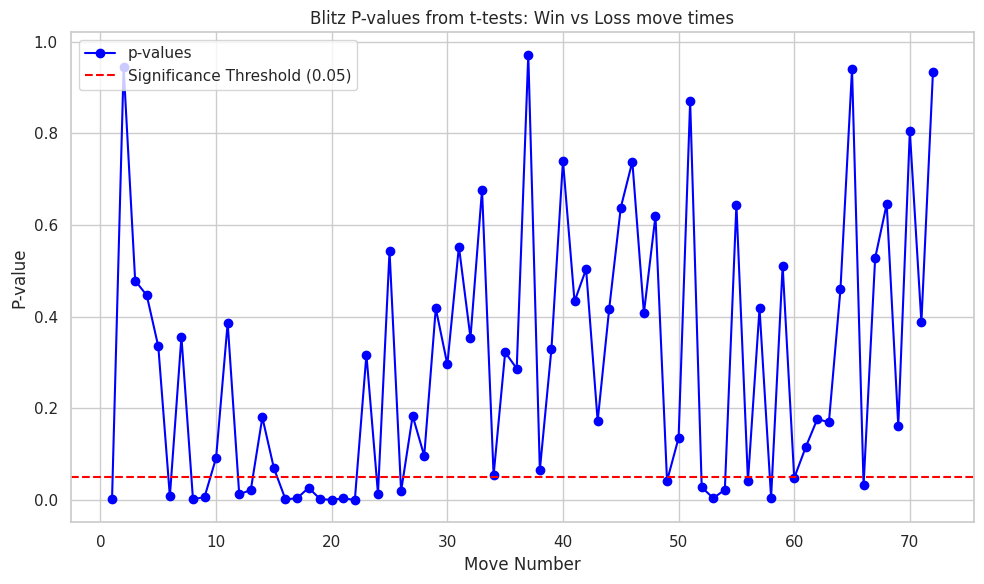

In [25]:
move_numbers = list(range(1, 75))

plt.figure(figsize=(10, 6))
plt.plot(move_numbers, p_values, marker='o', linestyle='-', color='blue', label='p-values')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Blitz P-values from t-tests: Win vs Loss move times')
plt.xlabel('Move Number')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We observe, between moves 1-20, more p-values yields results suggesting a difference. Also we can clearly see between moves 50-60 the p-values are more focused, which might suggest a pattern difference. We may conclude that for **Blitz Games** although we **fail to reject** the Null Hypothesis overall, if we examine spesific move intervals we can observe patterns that support the Alternative Hypothesis.

Now, we will examine the **Bullet Games**

In [39]:
# Dictionaries for move data. Keys are move no's.
move_win_dict2 = {i: [] for i in range(1, 200)}  # 200 to safely include all moves.
move_loss_dict2 = {i: [] for i in range(1, 200)}

# Fill the dicts: Win
for move_time, move_number in zip(bullet_move_times_win, bullet_move_numbers_win):
    if move_number in move_win_dict2:
        move_win_dict2[move_number].append(move_time)

# Loss
for move_time, move_number in zip(bullet_move_times_loss, bullet_move_numbers_loss):
    if move_number in move_loss_dict2:
        move_loss_dict2[move_number].append(move_time)

count = 0
p_values1 = []
for move_number in range(1, 66): # We observe insufficient data above this limit, because there are few games in such length.
  t_statistic, p_value = stats.ttest_ind(move_win_dict2[move_number], move_loss_dict2[move_number], equal_var=False)
  if p_value < 0.05:
    count += 1
  p_values1.append(p_value)
  print(f"Move Number: {move_number} t-stat: {t_statistic} p_value: {p_value}")

print(f"\nTotal count of moves that yielded a significant difference: {count}")


Move Number: 1 t-stat: -0.30972990566538844 p_value: 0.7568238260011301
Move Number: 2 t-stat: -0.6050553973876988 p_value: 0.5452617512792536
Move Number: 3 t-stat: -2.8005187642915508 p_value: 0.005209495243992229
Move Number: 4 t-stat: -1.501171878294762 p_value: 0.13359800664332383
Move Number: 5 t-stat: -1.5760298370225028 p_value: 0.115313346388673
Move Number: 6 t-stat: -2.239204305140437 p_value: 0.025361405677524183
Move Number: 7 t-stat: -1.0419140868705556 p_value: 0.2976779342385522
Move Number: 8 t-stat: -0.9021583369663548 p_value: 0.3671696219296581
Move Number: 9 t-stat: -1.9600863916292675 p_value: 0.05026716396089133
Move Number: 10 t-stat: -0.27705062103280353 p_value: 0.7817929519351521
Move Number: 11 t-stat: -2.1571923985597645 p_value: 0.031223595089080118
Move Number: 12 t-stat: -1.4612538590414388 p_value: 0.1442739073685665
Move Number: 13 t-stat: -1.9667764245230321 p_value: 0.04948517361453368
Move Number: 14 t-stat: -2.5592651158325705 p_value: 0.0106332108

Out of 64 successful t-tests, we observe 23 p-values that suggest a difference. This is a similar result to what we obtain from the Blitz Games. Let's plot the p-values for further examination.

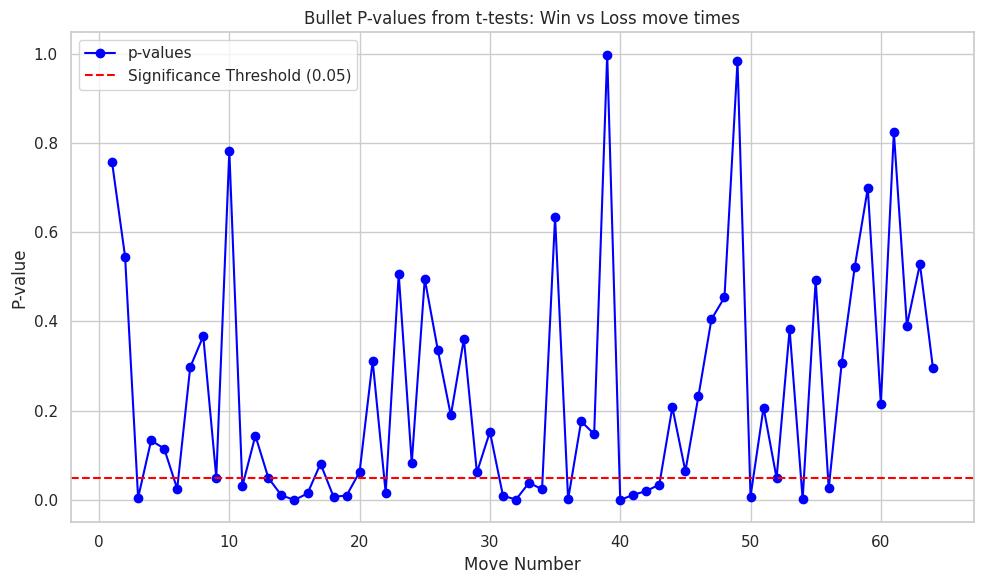

In [27]:
move_numbers = list(range(1, 66))

plt.figure(figsize=(10, 6))
plt.plot(move_numbers, p_values1, marker='o', linestyle='-', color='blue', label='p-values')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Bullet P-values from t-tests: Win vs Loss move times')
plt.xlabel('Move Number')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The plot suggests that for **Bullet Games** just like the Blitz Games, there are significant differences between Won and Loss games in spesific intervals.

We conclude, for **Bullet Games** we **fail to reject** the Null Hypothesis.

Note: We may suggest that there are intervals of moves that likely suggest a pattern, thus may yield results in favor of the Alternative Hypothesis.

Lastly, we will examine **Rapid Games**

In [28]:
# Dictionaries for move data. Keys are move no's.
move_win_dict3 = {i: [] for i in range(1, 200)}  # 200 to safely include all moves.
move_loss_dict3 = {i: [] for i in range(1, 200)}

# Fill the dicts: Win
for move_time, move_number in zip(rapid_move_times_win, rapid_move_numbers_win):
    if move_number in move_win_dict3:
        move_win_dict3[move_number].append(move_time)

# Loss
for move_time, move_number in zip(rapid_move_times_loss, rapid_move_numbers_loss):
    if move_number in move_loss_dict3:
        move_loss_dict3[move_number].append(move_time)

count = 0
for move_number in range(1, 68): # We observe insufficient data above this limit, because there are few games in such length.
  t_statistic, p_value = stats.ttest_ind(move_win_dict3[move_number], move_loss_dict3[move_number], equal_var=False)
  if p_value < 0.05:
    count += 1
  print(f"Move Number: {move_number} t-stat: {t_statistic} p_value: {p_value}")

print(f"\nTotal count of moves that yielded a significant difference: {count}")


Move Number: 1 t-stat: -0.5422833918574405 p_value: 0.5896396334851387
Move Number: 2 t-stat: 0.21063055014811502 p_value: 0.8337461730722026
Move Number: 3 t-stat: -0.2702791156842888 p_value: 0.7882010997658611
Move Number: 4 t-stat: -1.584419656276458 p_value: 0.12039771203281219
Move Number: 5 t-stat: -0.5547399452284447 p_value: 0.5808922053765508
Move Number: 6 t-stat: -0.053337155120408625 p_value: 0.9576072872080217
Move Number: 7 t-stat: -0.9334001801249575 p_value: 0.3547937909642571
Move Number: 8 t-stat: -1.4274989738359523 p_value: 0.1595199939798892
Move Number: 9 t-stat: 1.009358571613399 p_value: 0.3166905009920734
Move Number: 10 t-stat: -1.502996557081128 p_value: 0.1405885000729951
Move Number: 11 t-stat: 0.07899721908352432 p_value: 0.9372812739209819
Move Number: 12 t-stat: -0.9444250403987872 p_value: 0.3491712148759345
Move Number: 13 t-stat: -0.2357053136889389 p_value: 0.8143714144851739
Move Number: 14 t-stat: -0.8874246060210933 p_value: 0.3788123093091692
Mo

Out of 65 successful t-tests for each move of **Rapid Games** we observe only 2 significant p-values. This strongly suggests that even without the need of examining move intervals, we **fail to reject** the Null Hypothesis.

**Insights:**
- Although I failed to reject the Null Hypotheses, it is clear that there exists a pattern in spesific move intervals. These intervals may be examined to obtain a proving result to reject the Null Hypotheses, as a future work.

- There are significant differences in results between games of different time classes. This could be taken into consideration as a future work.

- It may be possible to predict game outcome during a continuing game, with applying ML methods. The pattern difference we found between moves 1-20 also support this idea. These early moves may be a strong indicator for the outcome.

## **Machine Learning**

Import the necessary libraries for **preparing data**, **feature engineering**, and **model training**.

In [29]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc

We will choose the best perfoming time class from the *Hypothesis Testing* part, i.e. the one with the highest ratio of **significant p-values**, which was the **Bullet** class. This is because, our models will be more precise if we use the data with highest pattern difference among wins and losses.

We can always change the time class by simply editing the `time_class_ML` variable, if we were to examine and build models with other categories too.

In [30]:
time_class_ML = 'bullet'

# We will use a new data frame for the ML part. The parameters will be created using the 'move_times' data of our main dictionary.
ml_df = pd.DataFrame()

# Some general features created from 'move_times'
ml_df['avg_move_time'] = df['move_times'].apply(lambda x: sum(x) / len(x) if x else 0)
ml_df['std_move_time'] = df['move_times'].apply(lambda x: pd.Series(x).std() if len(x) > 1 else 0)
ml_df['max_move_time'] = df['move_times'].apply(lambda x: max(x) if x else 0)
ml_df['min_move_time'] = df['move_times'].apply(lambda x: min(x) if x else 0)
ml_df['num_moves'] = df['move_times'].apply(lambda x: len(x))

ml_df['time_class'] = df['time_class']

# Add the 'side' data too from the previous dictionary for more parameters.
ml_df['side'] = df['side'].apply(lambda x: 1 if x == 'white' else 0) # Black (0) and White (1) are normalized to binary.

ml_df['outcome'] = df['result'].apply(lambda x: 1 if x == 'win' else 0) # Game result is also converted to binary for convenience.

**Feature Engineering**

We will create new features based on the time spent per move data, to better capture the data behavior. More features will help the models to better identify and detect the pattern difference in win and loss games, which will increase the precision of our models.

I will create the following new feature parameters and place them into our ML dictionary:

- **avg_time_x_num_moves:** Product of average move time and number of moves, measures overall pacing volume.
- **max_to_avg_time_ratio:** Ratio of maximum move time to average move time, identifies large time outliers.

- **num_fast_moves:** Number of moves made under 1 second, reflects impulsive or time-pressured decisions.
- **num_slow_moves:** Number of moves taking more than 5 seconds, reflects deeper thinking moments.
- **prop_fast_moves:** Proportion of fast moves relative to total, normalized version of `num_fast_moves`.
- **prop_slow_moves:** Proportion of slow moves relative to total, normalized `num_slow_moves`.

- **total_time:** Total time spent on all moves, an overall duration measure.
- **opening_time_avg:** Average time spent in the opening third of the game, early-game behavior.
- **midgame_time_avg:** Average time spent in the middle third, usually where the game gets complicated.
- **endgame_time_avg:** Average time in the final third, often influenced by time pressure.

- **time_peak_move:** The move number where the longest thinking time occurred, marks hesitation point.
- **rush_count:** Count of moves done in less than 50% of average time, indicates rushed plays.
- **slow_count:** Count of moves taking more than 200% of average, indicates deep thinking.
- **time_trend_slope:** Slope of time spent over move number, shows whether player speeds up or slows down as game progresses.

In [31]:
ml_df['avg_time_x_num_moves'] = ml_df['avg_move_time'] * ml_df['num_moves']

ml_df['max_to_avg_time_ratio'] = ml_df.apply(
    lambda row: row['max_move_time'] / row['avg_move_time'] if row['avg_move_time'] != 0 else 0,
    axis=1
)

ml_df['num_fast_moves'] = df['move_times'].apply(lambda x: sum(1 for move_time in x if move_time < 1))

ml_df['num_slow_moves'] = df['move_times'].apply(lambda x: sum(1 for move_time in x if move_time > 5))

ml_df['prop_fast_moves'] = ml_df.apply(
    lambda row: row['num_fast_moves'] / row['num_moves'] if row['num_moves'] != 0 else 0,
    axis=1
)

ml_df['prop_slow_moves'] = ml_df.apply(
    lambda row: row['num_slow_moves'] / row['num_moves'] if row['num_moves'] != 0 else 0,
    axis=1
)

ml_df['total_time'] = df['move_times'].apply(lambda x: sum(x))

ml_df['opening_time_avg'] = df['move_times'].apply(
    lambda x: np.mean(x[:len(x)//3]) if len(x)//3 > 0 else 0 # First third.
)
ml_df['midgame_time_avg'] = df['move_times'].apply(
    lambda x: np.mean(x[len(x)//3:len(x)*2//3]) if len(x)*2//3 - len(x)//3 > 0 else 0 # The middle 3rd.
)
ml_df['endgame_time_avg'] = df['move_times'].apply(
    lambda x: np.mean(x[len(x)*2//3:]) if len(x) - len(x)*2//3 > 0 else 0 # Last third of the games.
)

ml_df['time_peak_move'] = df['move_times'].apply(
    lambda x: np.argmax(x) + 1 if len(x) > 0 else 0
)

ml_df['rush_count'] = df['move_times'].apply(
    lambda x: np.sum(np.array(x) < np.mean(x) * 0.5) if len(x) > 0 else 0
)

ml_df['slow_count'] = df['move_times'].apply(
    lambda x: np.sum(np.array(x) > np.mean(x) * 2) if len(x) > 0 else 0
)

ml_df['time_trend_slope'] = df['move_times'].apply(
    lambda x: np.polyfit(np.arange(len(x)), x, 1)[0] if len(x) >= 2 else 0
)

Let's separate the time class we have chosen and observe our new ML dictionary.

In [32]:
ml_df = ml_df[ml_df['time_class'] == time_class_ML].copy()

ml_df.head()

,avg_move_time,std_move_time,max_move_time,min_move_time,num_moves,time_class,side,outcome,avg_time_x_num_moves,max_to_avg_time_ratio,...,prop_fast_moves,prop_slow_moves,total_time,opening_time_avg,midgame_time_avg,endgame_time_avg,time_peak_move,rush_count,slow_count,time_trend_slope
0,1.377778,1.506674,6.0,0.0,18,bullet,1,1,24.8,4.354839,...,0.666667,0.055556,24.8,0.666667,1.250000,2.216667,16,7,3,0.108153
1,1.151923,1.072013,5.1,0.1,52,bullet,0,0,59.9,4.427379,...,0.480769,0.019231,59.9,1.700000,1.405882,0.394444,17,17,6,-0.029800
2,1.286667,1.180639,4.8,0.0,45,bullet,0,0,57.9,3.730570,...,0.466667,0.000000,57.9,1.486667,1.846667,0.526667,16,16,6,-0.023017
3,1.480000,1.228863,3.9,0.0,20,bullet,0,0,29.6,2.635135,...,0.450000,0.000000,29.6,0.550000,1.371429,2.385714,15,8,4,0.122556
4,1.172549,0.925220,4.5,0.0,51,bullet,1,0,59.8,3.837793,...,0.529412,0.000000,59.8,1.700000,1.176471,0.641176,17,13,7,-0.026733


We will classify our features (inputs) as **X** and the targeted value for prediction as **Y** (which is the game outcome).

In [33]:
X = ml_df[[
    'avg_move_time',
    'std_move_time',
    'max_move_time',
    'min_move_time',
    'num_moves',
    'side',
    'avg_time_x_num_moves',
    'max_to_avg_time_ratio',
    'num_fast_moves',
    'num_slow_moves',
    'prop_fast_moves',
    'prop_slow_moves',
    'total_time',
    'opening_time_avg',
    'midgame_time_avg',
    'endgame_time_avg',
    'time_peak_move',
    'rush_count',
    'slow_count',
    'time_trend_slope'
]]
y = ml_df['outcome']

We will use %80 of our data for training the models, and the remaining %20 for testing our models.

*Note that the `random_state` value indicates randomness seed. I set it to a random value of 501 to generate the same result in all runs, for convenience. It is arbitrary and could be changed or discarded directly.*

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=501)

###**1. Logistic Regression Model**

I will use Logistic Regression Model algorithm, which is often used to predict binary outcomes, just like in our case: Win and Loss.

Once the model is trained, we will print out the respective **Accuracy Score**, **Classification Report**, and **Confusion Matrix**.

*Note that the parameter `max_iter` is set by me to an arbitrary safe value (generally 100 will do fine), to prevent possible warnings. The parameter is related to the self optimization of the model.*

In [35]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.7095435684647303

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.64      0.70       129
           1       0.65      0.79      0.72       112

    accuracy                           0.71       241
   macro avg       0.72      0.72      0.71       241
weighted avg       0.72      0.71      0.71       241


Confusion Matrix:
[[82 47]
 [23 89]]


The **Logistic Regression** model achieved an accuracy score of 71%.

The model yields a better **precision** ratio in identifying **Loss (0)** games, while it yields a better **recall** ratio in determining **Win (1)** games. As a result of this, it yields balanced **F1-scores** for both Win and Loss games.

From the **Confusion Matrix** we observe the following:

- **82 Loss** games are correctly classified.

- **89 Win** games are correctly classified.

- **47 Loss** games are misclassified as Win games.

- **23 Win** games are misclassified as Loss games.

The Logistic Regression model yields better results identifying **Win** games with a decent balance in identifying **Loss** games.

###**2. Random Forest Model**

Similar to the first model, we will train the model and display the **Accuracy Score**, **Classification Report**, and the **Confusion Matrix**.

*Again, note that, the parameter `random_state` is a randomness seed. I will use it to generate the same random result for all runs, to track the model better. The arbitrary 212 value can be changed or deleted.*

In [36]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=212)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf}")
print("\nRandom Forest Classification Report:")
print(report_rf)
print("\nRandom Forest Confusion Matrix:")
print(conf_matrix_rf)

Random Forest Accuracy: 0.7593360995850622

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.68      0.75       129
           1       0.70      0.85      0.77       112

    accuracy                           0.76       241
   macro avg       0.77      0.77      0.76       241
weighted avg       0.77      0.76      0.76       241


Random Forest Confusion Matrix:
[[88 41]
 [17 95]]


The **Random Forest** model achieved a higher accuracy score, with 76%.

The model yields a better **precision** ratio in identifying **Loss (0)** games, while it yields a better **recall** ratio in determining **Win (1)** games. As a result, it yields balanced **F1-scores** for both Win and Loss games.

From the **Confusion Matrix** we observe the following:

- **88 Loss** games are correctly classified.

- **95 Win** games are correctly classified.

- **41 Loss** games are misclassified as Win games.

- **17 Win** games are misclassified as Loss games.

The model shows a tendency of identifying **Win** games more precisely.

###**ROC Curve and AUC**

We will calculate the Area Under Curve (AUC) values for each model we trained to see which is better in predicting and distinguishing the game outcome.

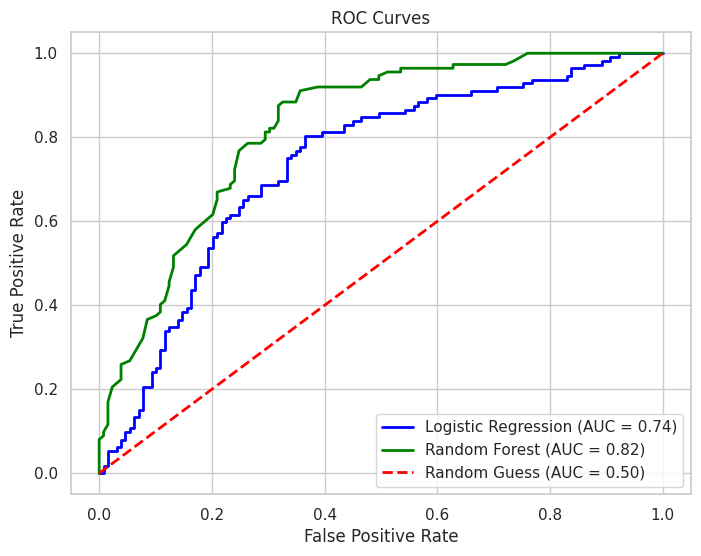


AUC for Logistic Regression: 0.7375
AUC for Random Forest: 0.8242


In [37]:
# ROC curve and AUC for Logistic Regression
y_pred_proba_lr = model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# ROC curve and AUC for Random Forest
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot of the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print()
print(f"AUC for Logistic Regression: {roc_auc_lr:.4f}")
print(f"AUC for Random Forest: {roc_auc_rf:.4f}")

The AUC results suggests that the **Random Forest** model is **stronger** in distinguishing the game outcome.

**Random Forest** with an **AUC of 0.82** performs significantly better than **Logistic Regression**, which yielded an **AUC of 0.74**.

The **AUC** provides us a more comprehensive view than the accuracy scores.

Since **Random Forest** yields an AUC of **0.8 <**, we could say it is a nearly excellent model for predicting the game outcome.